The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

In [91]:
import csv
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [92]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def remove_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
       file_path = os.path.join(folder_path, filename)
       if os.path.isfile(file_path):
          os.remove(file_path)
          # print(filename, "is removed")

In [93]:
def generate_trajectory(examplename="", speedchange=0, angle=-1, numexamples=5, fixed_initialspeed=None, fixed_angle=None, num_points=2500):
    for example in range(1,numexamples+1):
        filename = "results/synthetic_lanechangecitos/"+examplename+"_"+str(example)+".csv"
        
        timestamp = 0
        delta_t = 10**4  # Time step in microseconds
        initial_speed = fixed_initialspeed if fixed_initialspeed else (30 - example * 3) 
        lanechange_progress = 0
        was_lane_change = 0
        steering_angle_amplitude = fixed_angle if fixed_angle else (20 + example * 4) 
        
        with (open(filename, mode='w', newline='') as file):
                writer = csv.writer(file, delimiter=';')
                writer.writerow(["Time (seconds)", "Time (microseconds)", "Speed (m/s)", "Steering angle (deg)", "Lane change"])
                
                for i in range(0, num_points):                    
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0 else 1
                    
                    if was_lane_change != islanechange: lanechange_progress = 0
                    elif islanechange: lanechange_progress += 1
                    
                    turning_angle = - math.sin(timestamp*delta_t/10**10) * (steering_angle_amplitude+(example if not fixed_angle else 0)) * islanechange * angle
                    
                    was_lane_change = islanechange
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0.2 else 1
                    
                    speed = initial_speed + lanechange_progress / 40 * speedchange * (1 if not speedchange else (example+1)/2)
                    
                    writer.writerow([int(timestamp / 1000000), timestamp % 1000000, speed, turning_angle, islanechange])
                    timestamp += delta_t
            


In [94]:
remove_files_in_folder("results/synthetic_lanechangecitos/")

for dir in ["left", "right"]:
    generate_trajectory(examplename="lc"+dir+"_fixedspeed", speedchange=0, angle=-1, fixed_initialspeed=30)
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle", speedchange=0, angle=-1, fixed_angle=30)    
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle_speedup", speedchange=0.5, angle=-1, fixed_angle=30, fixed_initialspeed=30)
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle_speeddown", speedchange=-0.5, angle=-1, fixed_angle=30, fixed_initialspeed=30)


=== LCLEFT ===


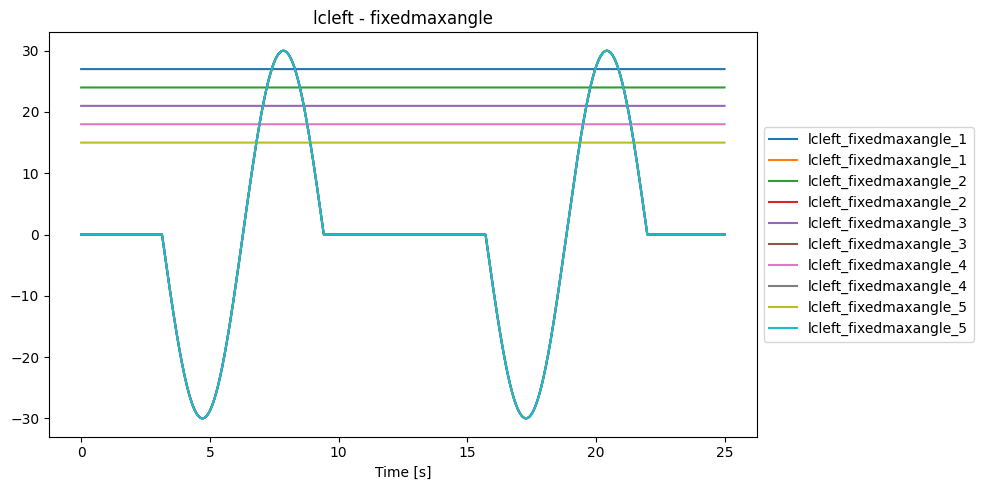

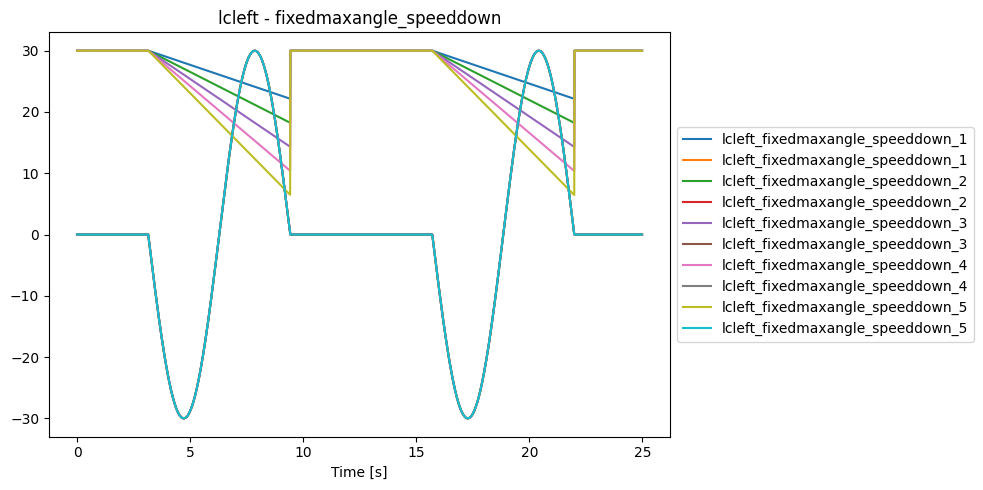

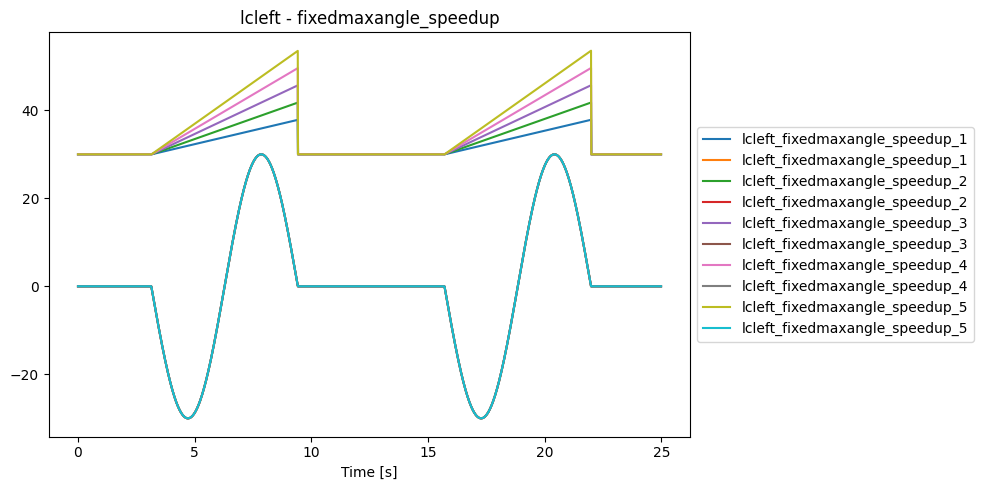

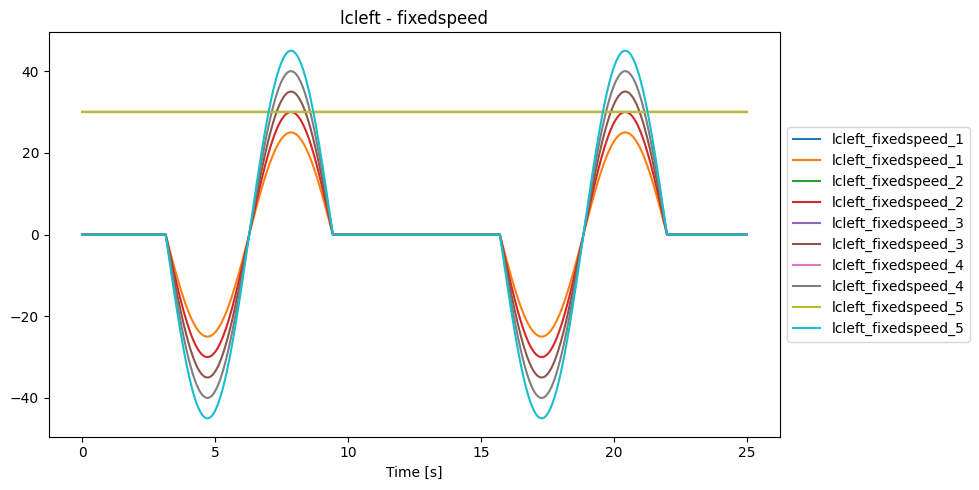


=== LCRIGHT ===


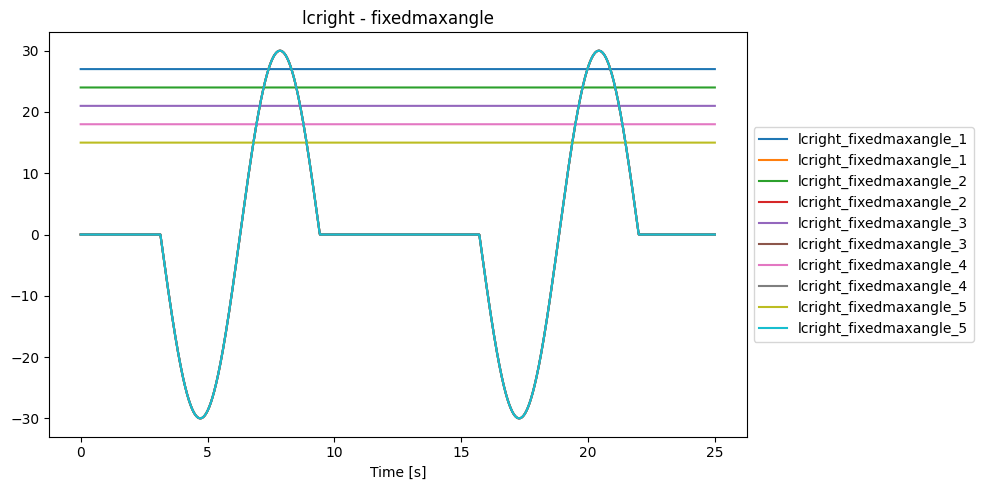

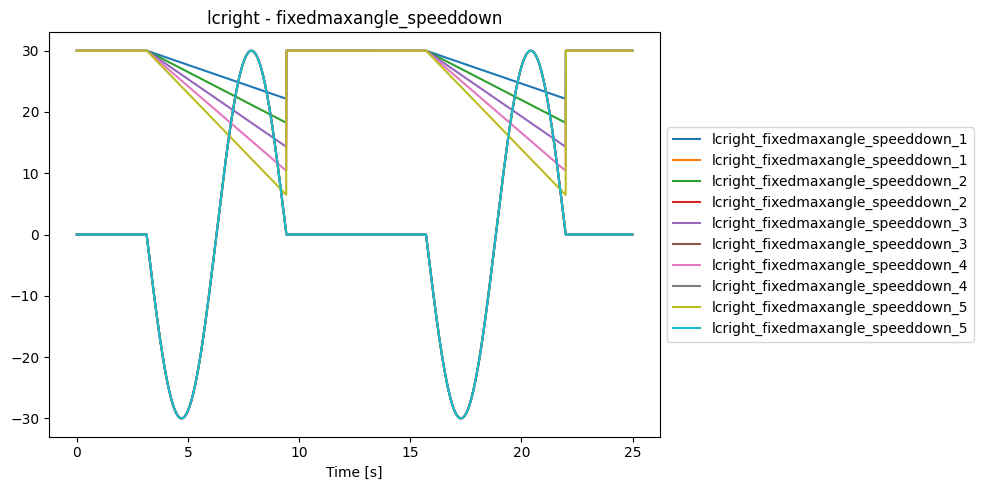

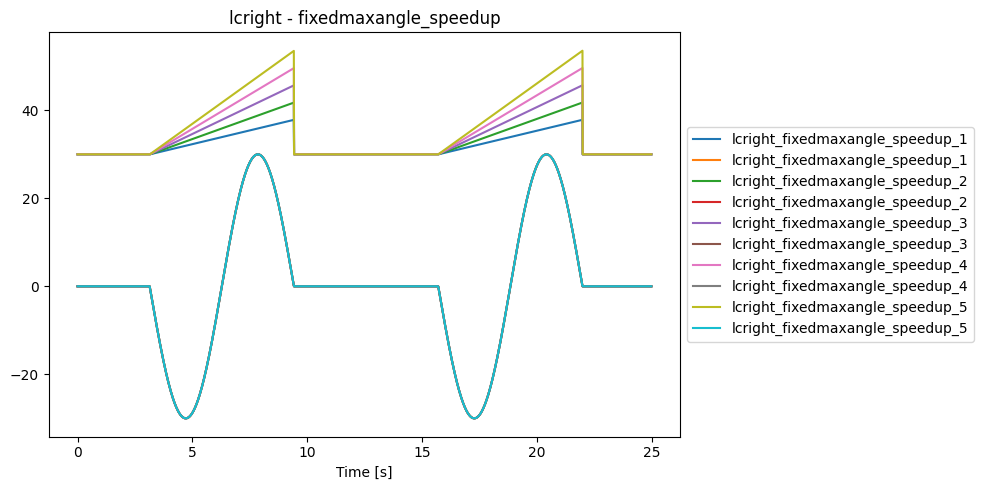

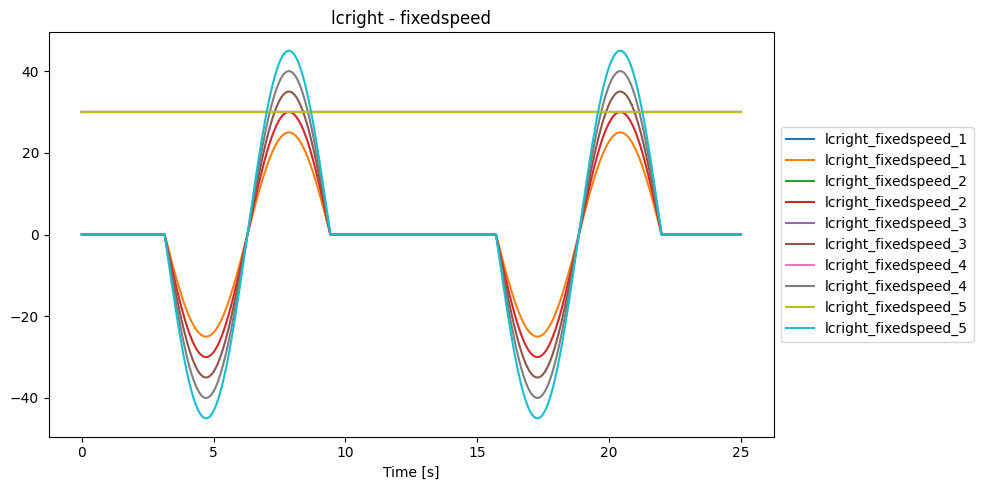

In [95]:
files = sorted(glob(os.path.join("results/synthetic_lanechangecitos/", "*.csv")))

# Group files by starting side (e.g., lcleft_ / lcright_)
grouped = {}
for f in files:
    base = os.path.basename(f)
    if not base.endswith(".csv"):
        continue

    # Extract start side and experiment type
    parts = base.replace(".csv", "").split("_")
    start = parts[0]  # lcleft or lcright
    exp_type = "_".join(parts[1:-1]) if len(parts) > 2 else parts[1]

    grouped.setdefault(start, {}).setdefault(exp_type, []).append(f)

# Plot each group separately
for start_side, exp_dict in grouped.items():
    print(f"\n=== {start_side.upper()} ===")
    for exp_name, file_list in exp_dict.items():
        fig, ax = plt.subplots(figsize=(10, 5))
        for f in file_list:
            data = pd.read_csv(f, sep=';')
            data['timestamp'] = data['Time (seconds)'] * 1_000_000 + data['Time (microseconds)']
            data['timestamp'] /= 1_000_000

            label = os.path.splitext(os.path.basename(f))[0]
            ax.plot(data['timestamp'], data['Speed (m/s)'], label=f"{label}")
            ax.plot(data['timestamp'], data['Steering angle (deg)'], label=f"{label}")

        ax.set_title(f"{start_side} - {exp_name}")
        ax.set_xlabel("Time [s]")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space for legend
        plt.show()